# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves. Thanks [Yandex Data School Analysis](https://github.com/yandexdataschool/Practical_DL/blob/fall21/week03_convnets/seminar_pytorch.ipynb) for this work!

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

![image](https://github.com/yandexdataschool/Practical_DL/raw/fall21/week03_convnets/cifar10.jpg)

In [1]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2022-05-25 11:27:16--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py.2’

cifar.py.2          100%[===================>]   2.34K  --.-KB/s    in 0s      

2022-05-25 11:27:16 (33.3 MB/s) - ‘cifar.py.2’ saved [2396/2396]



In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


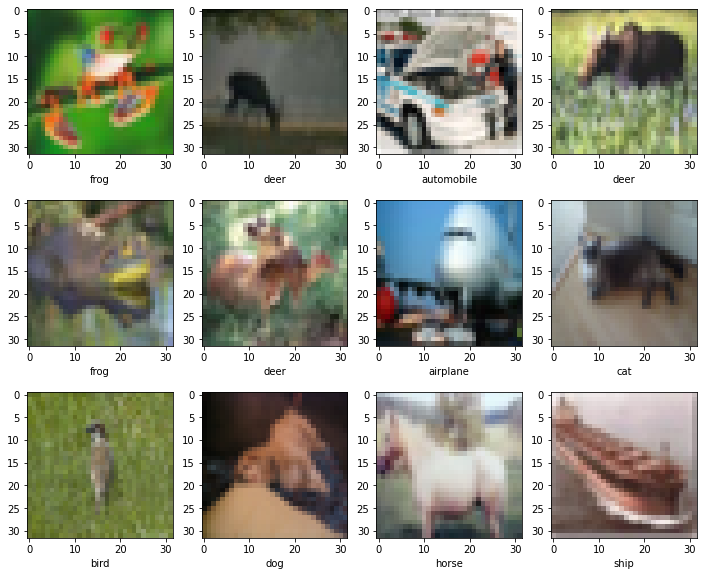

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [5]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [6]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [7]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.3075, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [8]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [9]:
import time

def train(model, opt, num_epochs=20, batch_size=50):
    train_loss = []
    val_accuracy = []

    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        start_time = time.time()
        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.numpy())
            
        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
            y_pred = logits.max(1)[1].data.numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))

        
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

In [10]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)
train(model, opt, 5, 50)

Epoch 1 of 5 took 1.879s
  training loss (in-iteration): 	2.016818
  validation accuracy: 			33.19 %
Epoch 2 of 5 took 2.777s
  training loss (in-iteration): 	1.853011
  validation accuracy: 			36.82 %
Epoch 3 of 5 took 3.526s
  training loss (in-iteration): 	1.789323
  validation accuracy: 			38.48 %
Epoch 4 of 5 took 3.571s
  training loss (in-iteration): 	1.741450
  validation accuracy: 			39.18 %
Epoch 5 of 5 took 3.503s
  training loss (in-iteration): 	1.700907
  validation accuracy: 			41.52 %


Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.

### Final test

In [11]:
def test(model):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    with torch.no_grad():
        for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
            logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
            y_pred = logits.max(1)[1].data.numpy()
            test_batch_acc.append(np.mean(y_batch == y_pred))

    test_accuracy = np.mean(test_batch_acc)
        
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(
        test_accuracy * 100))

    if test_accuracy * 100 > 95:
        print("Double-check, than consider applying for NIPS'17. SRSly.")
    elif test_accuracy * 100 > 90:
        print("U'r freakin' amazin'!")
    elif test_accuracy * 100 > 80:
        print("Achievement unlocked: 110lvl Warlock!")
    elif test_accuracy * 100 > 70:
        print("Achievement unlocked: 80lvl Warlock!")
    elif test_accuracy * 100 > 60:
        print("Achievement unlocked: 70lvl Warlock!")
    elif test_accuracy * 100 > 50:
        print("Achievement unlocked: 60lvl Warlock!")
    else:
        print("We need more magic! Follow instructons below")

In [12]:
test(model)

Final results:
  test accuracy:		41.37 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [13]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.MaxPool2d(3, stride=3),
    nn.ReLU(),
    Flatten(),
    nn.Linear(10 * 10 * 10, 100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
)

opt = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10 
batch_size = 50

train(model, opt, num_epochs, batch_size)

Epoch 1 of 10 took 8.468s
  training loss (in-iteration): 	1.838395
  validation accuracy: 			40.57 %
Epoch 2 of 10 took 8.896s
  training loss (in-iteration): 	1.669678
  validation accuracy: 			41.35 %
Epoch 3 of 10 took 9.013s
  training loss (in-iteration): 	1.637046
  validation accuracy: 			39.99 %
Epoch 4 of 10 took 8.870s
  training loss (in-iteration): 	1.608837
  validation accuracy: 			41.37 %
Epoch 5 of 10 took 8.802s
  training loss (in-iteration): 	1.603876
  validation accuracy: 			43.68 %
Epoch 6 of 10 took 8.893s
  training loss (in-iteration): 	1.580321
  validation accuracy: 			43.94 %
Epoch 7 of 10 took 8.990s
  training loss (in-iteration): 	1.569974
  validation accuracy: 			44.37 %
Epoch 8 of 10 took 9.857s
  training loss (in-iteration): 	1.560245
  validation accuracy: 			43.16 %
Epoch 9 of 10 took 9.022s
  training loss (in-iteration): 	1.547034
  validation accuracy: 			44.05 %
Epoch 10 of 10 took 9.015s
  training loss (in-iteration): 	1.536804
  validation 

In [14]:
test(model)

Final results:
  test accuracy:		43.27 %
We need more magic! Follow instructons below



__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [15]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3),
    nn.MaxPool2d(3, stride=3),
    nn.BatchNorm2d(10),
    nn.ReLU(),
    Flatten(),
    nn.Linear(10 * 10 * 10, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(100, 10)
)

opt = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 10 
batch_size = 50

train(model, opt, num_epochs, batch_size)

Epoch 1 of 10 took 8.590s
  training loss (in-iteration): 	1.401872
  validation accuracy: 			56.20 %
Epoch 2 of 10 took 8.361s
  training loss (in-iteration): 	1.156691
  validation accuracy: 			51.44 %
Epoch 3 of 10 took 8.431s
  training loss (in-iteration): 	1.052584
  validation accuracy: 			61.39 %
Epoch 4 of 10 took 8.573s
  training loss (in-iteration): 	0.970883
  validation accuracy: 			64.13 %
Epoch 5 of 10 took 8.269s
  training loss (in-iteration): 	0.913783
  validation accuracy: 			63.74 %
Epoch 6 of 10 took 8.466s
  training loss (in-iteration): 	0.866448
  validation accuracy: 			61.84 %
Epoch 7 of 10 took 8.515s
  training loss (in-iteration): 	0.813567
  validation accuracy: 			60.46 %
Epoch 8 of 10 took 8.438s
  training loss (in-iteration): 	0.779675
  validation accuracy: 			64.72 %
Epoch 9 of 10 took 8.379s
  training loss (in-iteration): 	0.745934
  validation accuracy: 			65.23 %
Epoch 10 of 10 took 8.475s
  training loss (in-iteration): 	0.715593
  validation 

In [16]:
test(model)

Final results:
  test accuracy:		65.02 %
Achievement unlocked: 70lvl Warlock!



## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [17]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [18]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


training loss: 	1.586656


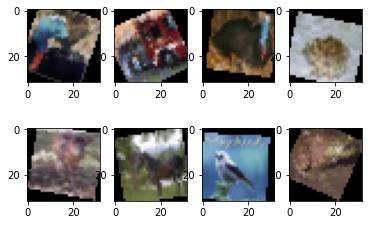

In [19]:
train_loss = 0

for (x_batch, y_batch) in train_batch_gen:
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(np.clip(img.transpose([1, 2, 0]) * stds + means, 0, 1))
        
    model.train()
    opt.zero_grad()
    loss = compute_loss(x_batch, y_batch)
    loss.backward()
    opt.step()
    train_loss += loss.item()

print("training loss: \t{:.6f}".format(train_loss / len(train_batch_gen)))

When testing, we don't need random crops, just normalize with same statistics.

In [20]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test)

# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


In [21]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
transform_train = transforms.Compose([
   transforms.RandomCrop(32, padding=4),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./cifar_data/', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar_data/', train=False, download=True, transform=transform_test)

n = len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(0.9 * n), n - int(0.9 * n)])
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=True, num_workers=2)

test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block_0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.residual_block_0 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.residual_block_1 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU()
        )
        self.linear = nn.Linear(64, 10)

    def forward(self, imgs):
        batch_size = imgs.size()[0]
        out_0 = self.conv_block_0(imgs)
        rout_0 = self.residual_block_0(out_0)
        out_1 = rout_0 + out_0
        out_1 = self.conv_block_1(out_1)
        rout_1 = self.residual_block_1(out_1)
        out_2 = rout_1 + out_1
        out_2 = self.conv_block_2(out_2)
        return self.linear(out_2.view(batch_size, -1))

In [24]:
num_epochs = 30
model = Classifier().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
metric = nn.CrossEntropyLoss()

In [25]:
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    val_acc = 0 

    model.train()
    for imgs, labels in tqdm(train_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        opt.zero_grad()
        loss = metric(preds, labels)
        loss.backward()
        opt.step()
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(val_dataloader):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            pred_labels = torch.argmax(preds, dim=1)
            val_acc += torch.sum(pred_labels == labels)

    print("training loss: \t{:.6f}".format(train_loss / len(train_dataloader)))
    print("validation accuracy: \t{:.6f}".format(val_acc / len(val_dataloader.dataset)))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	1.702086
validation accuracy: 	0.467800


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	1.291174
validation accuracy: 	0.555800


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	1.106893
validation accuracy: 	0.616200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.976143
validation accuracy: 	0.659400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.900596
validation accuracy: 	0.689200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.833211
validation accuracy: 	0.720200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.792808
validation accuracy: 	0.721200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.756631
validation accuracy: 	0.732400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.714271
validation accuracy: 	0.738600


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.692172
validation accuracy: 	0.742400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.665869
validation accuracy: 	0.773600


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.641076
validation accuracy: 	0.764000


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.624430
validation accuracy: 	0.795000


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.601347
validation accuracy: 	0.801000


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.585401
validation accuracy: 	0.770200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.567941
validation accuracy: 	0.796400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.556281
validation accuracy: 	0.804600


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.544139
validation accuracy: 	0.815400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.528657
validation accuracy: 	0.820400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.519271
validation accuracy: 	0.830600


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.508830
validation accuracy: 	0.829200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.493094
validation accuracy: 	0.828400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.488790
validation accuracy: 	0.847200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.479657
validation accuracy: 	0.838800


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.468352
validation accuracy: 	0.841200


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.463690
validation accuracy: 	0.836000


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.451442
validation accuracy: 	0.828800


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.446857
validation accuracy: 	0.805400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.439242
validation accuracy: 	0.859400


  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training loss: 	0.433857
validation accuracy: 	0.856200


In [26]:
test_acc = 0

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(test_dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        pred_labels = torch.argmax(preds, dim=1)
        test_acc += torch.sum(pred_labels == labels)

print("test accuracy: \t{:.6f}".format(test_acc / len(test_dataloader.dataset)))   

  0%|          | 0/79 [00:00<?, ?it/s]

test accuracy: 	0.830500
